In [33]:
import numpy as np
import pandas as pd
import itertools
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.preprocessing import sequence
from keras.preprocessing.text import one_hot
import nltk
import csv
import string
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
# fix random seed for reproducibility
np.random.seed(7)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# !pip install nltk

     |████████████████████████████████| 1.5MB 19.0MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449907 sha256=c9154ee1b78fee426e9c25afc8184549b00ed3143f1da748ab800e2bde1a5b8b
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
cd storage/

/storage


In [5]:
!ls

lost+found  test.tsv  train.tsv


In [2]:
df = pd.read_csv('train.tsv', sep='\t', header=0)

NameError: name 'pd' is not defined

In [ ]:
df1 = pd.read_csv('test.tsv', sep='\t', header=0)

In [1]:
df.shape

NameError: name 'df' is not defined

In [32]:
df.head()

,label,text
0,0,"NASCAR organized the NASCAR Thunder 100 , a pa..."
1,1,"Like its sister project Wikipedia , Wiktionary..."
2,1,There are two ways to combine the many dispara...
3,1,"Rodolphus Agricola , Dutch scholar and humanis..."
4,0,Proxima Centauri was found to share the same p...


In [8]:
vocabulary_size = 8000
unknown_token = "UNKNOWN_TOKEN"

In [9]:
sentences = itertools.chain(*[nltk.word_tokenize(x['text'].lower()) for _,x in df.iterrows()])
  # sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
sentences = list(sentences)
  # print ("Parsed %d sentences." % (len(sentences)))

In [10]:
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

In [11]:
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))

In [12]:
vocab = word_freq.most_common(vocabulary_size)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

In [13]:
X = []
for row in df['text']:
  row = row.translate(str.maketrans('','',string.punctuation))
  row = row.lower()
  token = nltk.word_tokenize(row)
  token = [w if w in word_to_index else unknown_token for w in token]
  # print(token)
  X.append([word_to_index[w] for w in token])
X = np.array(X)
y = np.array(df['label'])

In [52]:
encoded_docs = []
for d in df['text']:
    d = d.translate(str.maketrans('','',string.punctuation))
    d = d.lower()
    encoded_docs.append(one_hot(d,vocabulary_size))

nascar organized the nascar thunder 100  a pair of exhibition 100lap races on the east circuit 


'NASCAR organized the NASCAR Thunder 100 , a pair of exhibition 100-lap races on the East Circuit .'

In [61]:
X_train, X_test, y_train, y_test = train_test_split(encoded_docs[:40000], y[:40000], test_size=0.3, random_state=7)

In [62]:
top_words = 8000
# truncate and pad input sequences
max_review_length = 80
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [56]:
X_train

array([[   0,    0,    0, ..., 5618, 6814, 1316],
       [   0,    0,    0, ..., 3080, 6451,  186],
       [   0,    0,    0, ..., 4081, 1258, 3099],
       ...,
       [   0,    0,    0, ..., 4081, 6482, 5721],
       [   0,    0,    0, ..., 2311, 7319, 2942],
       [   0,    0,    0, ..., 4574, 5228, 6882]], dtype=int32)

In [21]:
#Try first 20000 sentences 
# X_train, X_test, y_train, y_test = train_test_split(X[:20000], y[:20000], test_size=0.3, random_state=7)

In [30]:
max(list(map(len,X_train)))

75

In [63]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=15, batch_size=32,validation_split=0.3)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 80, 64)            512000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                6800      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 518,821
Trainable params: 518,821
Non-trainable params: 0
_________________________________________________________________
None
Train on 19600 samples, validate on 8400 samples
Epoch 1/15
19600/19600 [==============================] - 55s 3ms/step - loss: 0.6770 - accuracy: 0.5892 - val_loss: 0.6605 - val_accuracy: 0.6127
Epoch 2/15
19600/19600 [==============================] - 54s 3ms/step - loss: 0.6532 - accuracy: 0.6216 - val_loss: 0.6502 - val_accuracy: 0.6248
Epoch 3/15
19600/19600 [=====

KeyboardInterrupt: 

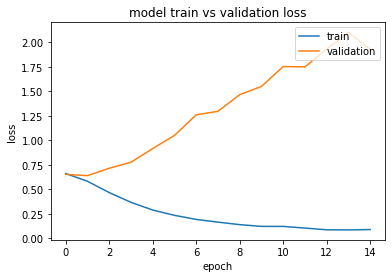

Accuracy: 59.67%


In [79]:
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model train vs validation loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper right')
# plt.show()
# # Final evaluation of the model
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Accuracy: %.2f%%" % (scores[1]*100))

In [53]:
a = model.predict(X_test)

In [61]:
t = np.zeros(a.shape)
t[a >= 0.5] = 1

array([ True])

In [69]:
sum(t.reshape((6000,)) == y_test)/len(y_test)

0.602

In [66]:
y_test.shape

(6000,)

In [68]:
t.reshape((6000,))

array([0., 1., 1., ..., 1., 0., 1.])

In [70]:
sum(y_train == 1)

6931

In [71]:
sum(y_train == 0)

7069

In [72]:
sum(y_test == 0)

3056

In [74]:
sum(y_test == 1)

2944

In [34]:
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']

In [36]:
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[47, 32], [35, 46], [30, 25], [35, 46], [12], [42], [16, 25], [26, 35], [16, 46], [15, 37, 32, 31]]
